In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/students-performance-in-exams/StudentsPerformance.csv


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

***In this work, we conduct a small research.***

- At first we will try to predict the GPA based on regressors such as parental education, race, child gender, type of school lunch, and of course, level of preparing for test. 

- Secondly, we will look for the most informative regressor

# Part 1

In [4]:
df = pd.read_csv('/kaggle/input/students-performance-in-exams/StudentsPerformance.csv')

In [5]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Let's calculate the average score for each student

In [6]:
def get_avr_score(df):
    df['average score'] = round((df['math score'] + df['reading score'] + df['writing score'])/3)
    return df

In [7]:
df = get_avr_score(df)

Before we start pre-processing our data, we need to separate it into training and testing.

In [8]:
X = df.drop(['math score','reading score','writing score','average score'], axis=1)
y = df['average score']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)

In [9]:
X_train

,gender,race/ethnicity,parental level of education,lunch,test preparation course
987,male,group E,some high school,standard,completed
515,female,group C,some high school,standard,completed
649,female,group D,some college,standard,completed
903,female,group D,bachelor's degree,free/reduced,completed
265,male,group D,some high school,free/reduced,none
...,...,...,...,...,...
177,female,group C,associate's degree,standard,completed
542,female,group C,associate's degree,standard,none
203,female,group B,associate's degree,standard,none
29,female,group D,master's degree,standard,none


As we can see, all regressors are of categorical type, so we have to convert it to numeric.
I'm going to use ordinal coding for gender, parental education level, lunch and test preparation course, and one-hot coding for race.

In [10]:
def get_gender(data):
    if data == 'male':
        return 1
    else:
        return 0

In [12]:
def get_lvl_of_edc(data):
    if data == "master's degree":
        return 6
    elif data == "bachelor's degree":
        return 5
    elif data == "associate's degree":
        return 4
    elif data == "some college":
        return 3
    elif data == "high school":
        return 2
    elif data == "some high school":
        return 1

In [13]:
def get_lunch(data):
    if data == 'standard':
        return 1
    else:
        return 0 

In [14]:
def get_test_pred_lvl(data):
    if data == 'completed':
        return 1
    else:
        return 0

In [15]:
def preprocessing(df):
    df['gender'] = df['gender'].apply(get_gender)
    df['parental level of education'] = df['parental level of education'].apply(get_lvl_of_edc)
    df['lunch'] = df['lunch'].apply(get_lunch)
    df['test preparation course'] = df['test preparation course'].apply(get_test_pred_lvl)
    df = pd.concat([df.drop('race/ethnicity', axis=1), pd.get_dummies(df['race/ethnicity'])], axis=1)
    return df

In [16]:
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)

In [17]:
corr = pd.concat([X_train,y_train],axis=1).corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  """


,gender,parental level of education,lunch,test preparation course,group A,group B,group C,group D,group E,average score
gender,1.00,-0.03,0.03,0.02,0.09,-0.01,-0.07,0.01,0.02,-0.14
parental level of education,-0.03,1.00,-0.04,0.00,-0.08,-0.07,0.06,-0.01,0.06,0.21
lunch,0.03,-0.04,1.00,-0.01,-0.02,0.03,-0.02,-0.02,0.04,0.29
test preparation course,0.02,0.00,-0.01,1.00,0.01,-0.02,0.03,-0.07,0.06,0.27
group A,0.09,-0.08,-0.02,0.01,1.00,-0.15,-0.20,-0.18,-0.13,-0.12
group B,-0.01,-0.07,0.03,-0.02,-0.15,1.00,-0.33,-0.30,-0.20,-0.07
group C,-0.07,0.06,-0.02,0.03,-0.20,-0.33,1.00,-0.40,-0.28,-0.03
group D,0.01,-0.01,-0.02,-0.07,-0.18,-0.30,-0.40,1.00,-0.25,0.06
group E,0.02,0.06,0.04,0.06,-0.13,-0.20,-0.28,-0.25,1.00,0.14
average score,-0.14,0.21,0.29,0.27,-0.12,-0.07,-0.03,0.06,0.14,1.00


In [38]:
algos = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          XGBRegressor(),
          KNeighborsRegressor(n_neighbors=3),
          SVC()
        ]
new_df = {'Model':[], 'MAE in train':[], 'MAE in test': []}
#       'Cros Val score':[]}

for algo in algos:
    algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    
    new_df['Model'].append(str(algo)[:str(algo).find('(')])
    new_df["MAE in train"].append(mean_absolute_error(y_train, algo.predict(X_train)))
    new_df["MAE in test"].append(mean_absolute_error(y_test, y_pred))
#     new_df["Cros Val score"].append(-1*cross_val_score(algo, X, y, cv=5, scoring='neg_mean_absolute_error').mean())
new_df = pd.DataFrame(new_df)

In [39]:
new_df

,Model,MAE in train,MAE in test
0,LinearRegression,9.980169,10.198296
1,DecisionTreeRegressor,8.487564,11.950194
2,RandomForestRegressor,8.733854,11.430489
3,XGBRegressor,8.513745,11.775489
4,KNeighborsRegressor,10.023333,11.428333
5,SVC,11.720000,11.310000


# Part 2

***All models work approximately the same, we take xgboosting and look at the shap value to conclude which regressors are important***

In [20]:
model = XGBRegressor()
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


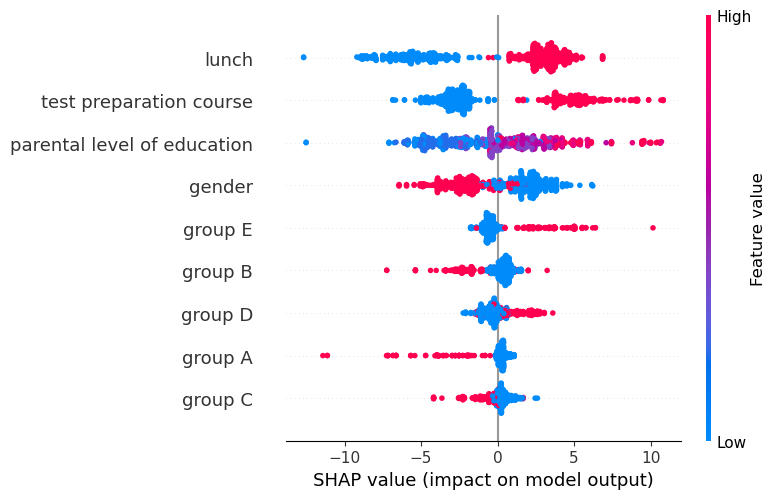

In [40]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values,X_train)

**Obviously the most important regressors  are 'lunch', 'parental lvl of education' and 'test prep. course', because they perfectly differentiates objects into 2 classes and they have the biggest varience**

It should be interesting to see, how every regressor influence on average score for particular student

In [43]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value

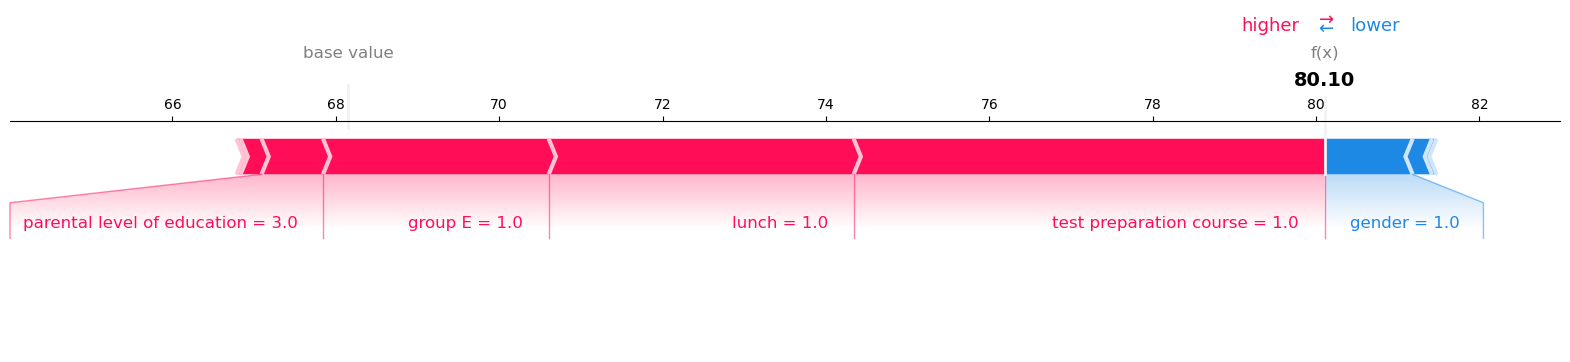

In [49]:
student_id = np.random.randint(0,801)
shap.force_plot(expected_value, shap_values[student_id], X_train.iloc[student_id], link='identity', matplotlib=True)

Below we have decided that the two most important regressors are “lunch”, 'parental lvl of education' and level of education of parents”, it is interesting to study how they together affect the target

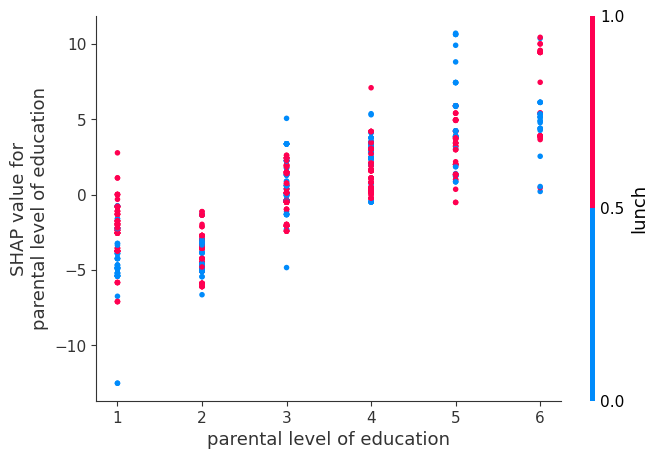

In [51]:
shap.dependence_plot('parental level of education', shap_values,X_train,interaction_index='lunch')

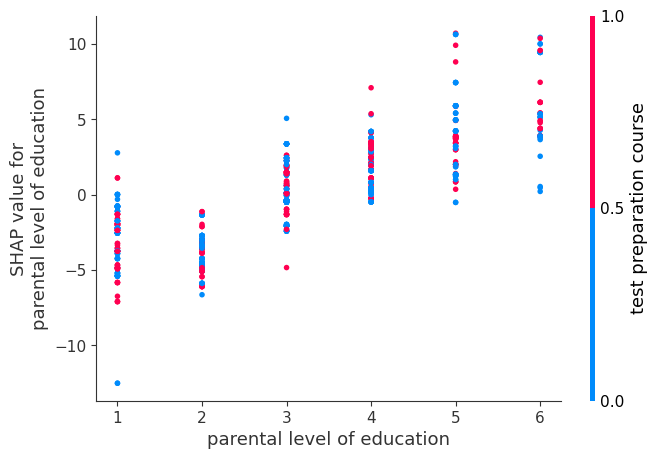

In [52]:
shap.dependence_plot('parental level of education', shap_values,X_train,interaction_index='test preparation course')

# Conclusion
**There, we see that students, whose parents have a lower level of education than 'some college', tend score lower than students, whose parents have a level of education higher.**